In [1]:
# This code is written by Yara Al-Shorman
# Date created: May 18 2022
# Last modified: Jun 6 2022
# Github repo: https://github.com/YaraAlShorman/Research-spring-22
# The purpose of this code is to predict the bulkflows for a large given set of galaxies (using machine learning)

### imports

In [2]:
# imports
import tensorflow as tf
from numpy import load, concatenate, expand_dims  # I am doing this to minimize unncessary imports, they take up too much RAM and time
from sklearn.preprocessing import MinMaxScaler
from math import floor
from matplotlib import pyplot as plt

#### disable gpu (for whatever reason)

In [3]:
# run this snippet to disable GPU

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


### checking for GPU

### tangent: running tensorflow with GPU

Tensorflow by default attempts to run on GPU if possible. If the capability to do so was not found, it runs on the CPU. <br>
To allow it to run on the GPU and you are using an NVIDIA graphics card, you must download the THE CORRECT VERSIONS of CUDNN, CUDA, Tensorflow, and Python. <br>
Yes, all of them have to match up. (It took me 2 days to figure that out) <br>
To check if your NVIDIA GPU is compatible (I dont know if this works for AMD GPUs): Refer to https://developer.nvidia.com/cuda-gpus <br>
I have a GTX 1650 TI with Max-Q capability. Which is compatible.<br>
Furthermore, you must ensure you have matching versions of Python, Tensorflow, CUDNN and CUDA. <br>
No, having the newest versions is not enough. <br>
I installed: <br>
CUDNN v11.2 <br>
CUDA v8.1 <br>
Tensorflow v2.9 <br>
Python v3.10 <br>
You also need a compatible version of Visual Studio (MSVC). I have MSVC 2019. <br>
Keep in mind that the newest versions of CUDA and CUDNN are 8.4 and 11.7, respectively. Which will NOT work. Pay careful attention to versions. <br>
Refer to this page for compatible versions: https://www.tensorflow.org/install/source_windows#gpu <br>
Of course, things are different if you are using Mac or Linux <br>

In [4]:
# checking that GPU is available
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
# to avoid memory allocation/resource errors with my GPU
# this prevents Tensorflow from allocating all the memory at once, and instead
# allocating it as necessary
# such that it doesn't exhaust the entire 4 GB of memory from the GPU

gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

### data preprocessing
loading, stacking, and scaling

In [7]:
tf.random.set_seed(982369253487)
# stacking all of the data into one humungous tensor
# I am using tensors because they can be ragged and can be stacked
# these means we won't have to cut off our data to standardize array sizes
data = load(f'C:/Users/yaras/Documents/Research/Feldman/distinct_data_only/processed-0-error-40.npz')
# data = load(f'C:/Users/yaras/Documents/Research/Feldman/TEST/rotated-0-TEST.npz')
input_data = data['data']
scaler = MinMaxScaler()
scaler.fit(input_data)
input_data = scaler.transform(input_data)
input_data = tf.expand_dims(input_data, axis=0)
input_data = tf.RaggedTensor.from_tensor(input_data)
# if scaling the data this way doesn't work good enough, i can try scaling all the data at once, to one scale
# in this case, i am scaling every 'square' of data seprately
# i should try scaling the entire 'cube' at once

output_data = tf.convert_to_tensor(data['header'])
output_data = tf.expand_dims(output_data, axis=0)

num_of_files = 300  # variable for number of files to load, current limit is 3000
files_acc = range(0, num_of_files)

for i in files_acc: # limit 3000
        array_data = load(f'C:/Users/yaras/Documents/Research/Feldman/distinct_data_only/processed-{i}-error-40.npz')
        # array_data = load(f'C:/Users/yaras/Documents/Research/Feldman/TEST/rotated-{i}-TEST.npz')
        # 'data' data
        temp = tf.convert_to_tensor(array_data['data'], dtype='float64')
        scaler = MinMaxScaler()
        scaler.fit(temp)
        temp = scaler.transform(temp)
        temp = tf.expand_dims(temp, axis=0)  # dimensions have to be expandad to be able to concat along the outer-dimension 
        input_data = tf.concat([input_data, temp], axis=0)  # concat adds to existing dimensions, does not create new ones
        # 'input_data' is a tensor

        # 'header' data (bulkflows)
        temp = array_data['header']
        temp = expand_dims(temp, axis=0)
        output_data = concatenate([output_data, temp], axis=0)
        # 'output_data' is an array, because it is uniform 
        # i scale it (normalize it) all at once, then i convert it to a tensor

# next is scaling

# normalizing/scaling the data
scaler = MinMaxScaler()
scaler.fit(output_data)
output_data = scaler.transform(output_data)
output_data = tf.convert_to_tensor(output_data)

input_data = input_data.to_tensor()  # trunactes the tensor to largest possible size w/o padding, currently being: [batch_size, 11009, 4]

# splitting the data into train/test sections
# 75% -> train
# 25% -> test
test_percent = 0.25
cuttoff = len(files_acc) * test_percent
input_test, input_train = (input_data[:floor(cuttoff)], \
                                input_data[floor(cuttoff)::])
output_test, output_train = (output_data[:floor(cuttoff)], \
                                output_data[floor(cuttoff)::])

output_test = scaler.inverse_transform(output_test)

# data is split and ready for the model

### model creation

In [10]:
# Creating a model using model API (the harder way)
# hl stands for 'hidden-layer'


inputs = tf.keras.Input(shape=[10944, 4], ragged=False)
hl1 = tf.keras.layers.Conv1D(64, 16, activation='relu')(inputs)
hl2 = tf.keras.layers.Conv1D(32, 6, activation='tanh')(hl1)
hl3 = tf.keras.layers.Conv1D(32, 4, activation='relu')(hl2)
# hl4 = tf.keras.layers.Conv1D(4, 2, use_bias=True)(hl3)
flat = tf.keras.layers.Flatten()(hl3)
# hl4 = tf.keras.layers.Dense(16, activation='relu')(flat)
outputs = tf.keras.layers.Dense(3, activation='linear')(flat)
model0 = tf.keras.Model(inputs=inputs, outputs=outputs)

model0.compile(loss='mse', 
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # do not change learning rate as i have found 0.001 (for Adam) to be the most optimal rate
               metrics=['accuracy'])

model0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10944, 4)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 10929, 64)         4160      
                                                                 
 conv1d_4 (Conv1D)           (None, 10924, 32)         12320     
                                                                 
 conv1d_5 (Conv1D)           (None, 10921, 32)         4128      
                                                                 
 flatten_1 (Flatten)         (None, 349472)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1048419   
                                                                 
Total params: 1,069,027
Trainable params: 1,069,027
Non-tra

In [11]:
a = model0.fit(input_train, output_train, epochs=5, use_multiprocessing=True, workers=1000)

Epoch 1/5
8/8 [==============================] - 5s 490ms/step - loss: 0.1412 - accuracy: 0.5487
Epoch 2/5
8/8 [==============================] - 4s 487ms/step - loss: 0.0737 - accuracy: 0.6372
Epoch 3/5
8/8 [==============================] - 4s 486ms/step - loss: 0.0397 - accuracy: 0.6283
Epoch 4/5
8/8 [==============================] - 4s 485ms/step - loss: 0.0377 - accuracy: 0.5619
Epoch 5/5
8/8 [==============================] - 4s 484ms/step - loss: 0.0339 - accuracy: 0.6416


### testing & graphing results

In [12]:
output_pred = model0.predict(input_test)

# recall that scaler = MinMaxScaler(), it uses the same transformer I used to scale the data initally to un-scale it
output_pred = scaler.inverse_transform(output_pred)

print(output_test)
print(output_pred)

3/3 [==============================] - 0s 75ms/step
[[ -25.39076889  148.71427005 -144.27017343]
 [ -25.39076889  148.71427005 -144.27017343]
 [ 100.86102729    1.1439279  -203.83560692]
 [-208.72128374   49.10202383 -124.09919739]
 [  -4.62407516 -104.04408259  102.47271468]
 [ -38.8056201   -90.95534852 -251.26885033]
 [ -30.1299643    34.2618963   -33.38143386]
 [  59.18985885 -113.52450527  129.18291167]
 [  43.22393162 -114.73603399  242.45084045]
 [-117.35181212    4.95540761 -124.76243216]
 [ -18.13062225    1.73420516 -105.73907297]
 [-267.07036194  149.06896897  -62.34410113]
 [ 113.14392164  -11.69223706 -115.44708239]
 [  31.69586292  125.45655104 -129.28033905]
 [  61.99160544  130.2126379    31.73576745]
 [ -29.74991627  -89.34430587   87.31252805]
 [ -74.32099511  -71.93984563  -65.64130376]
 [  31.53846917   80.48645791  -53.00860199]
 [ 107.43248976  -27.73257745 -128.35267334]
 [-119.53175445 -109.33184553 -163.0360985 ]
 [ -66.8111089  -201.85123355  -67.70860593]
 [ 

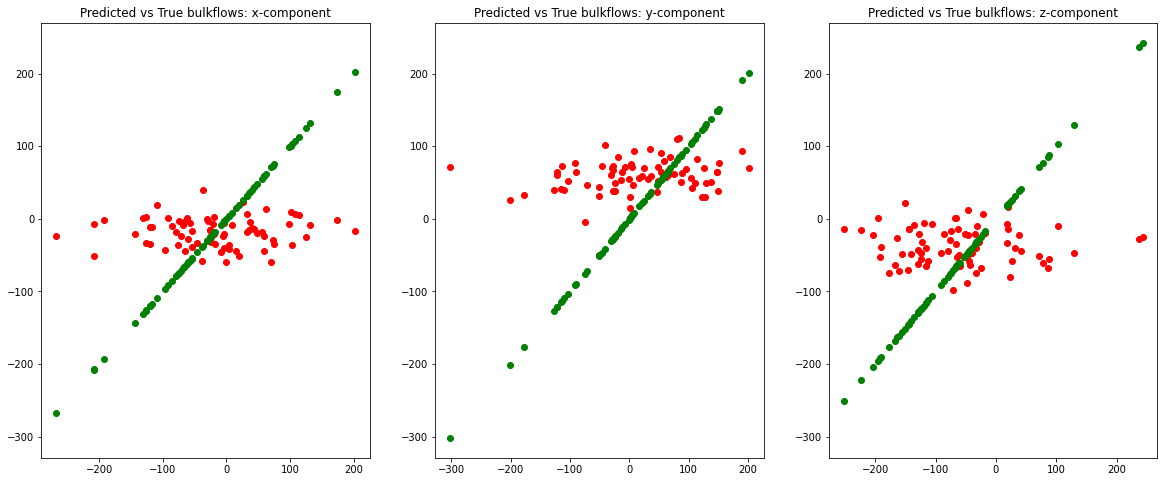

In [13]:
# producing tensors of the true/predicted magnitues of the bulkflow
# basically pythagorean theorem
# magnitude = sqrt(x^2 + y^2 + z^2)

bf = tf.math.sqrt(tf.math.pow(output_test[:, 0], 2) + tf.math.pow(output_test[:, 1], 2) + tf.math.pow(output_test[:, 2], 2))
pred_bf = tf.math.sqrt(tf.math.pow(output_pred[:, 0], 2) + tf.math.pow(output_pred[:, 1], 2) + tf.math.pow(output_pred[:, 2], 2))

# GREEN is TRUE
# RED is PREDICTED

fig = plt.figure()
fig.set_figheight(8) 
fig.set_figwidth(20)

bx = fig.add_subplot(1, 3, 1)
plt.scatter(output_test[:, 0], output_pred[:, 0], color='red')
plt.scatter(output_test[:, 0], output_test[:, 0], color='green')
plt.title('Predicted vs True bulkflows: x-component')


by = fig.add_subplot(1, 3, 2, sharey=bx)
plt.scatter(output_test[:, 1], output_pred[:, 1], color='red')
plt.scatter(output_test[:, 1], output_test[:, 1], color='green')
plt.title('Predicted vs True bulkflows: y-component')

bz = fig.add_subplot(1, 3, 3, sharey=bx)
plt.scatter(output_test[:, 2], output_pred[:, 2], color='red')
plt.scatter(output_test[:, 2], output_test[:, 2], color='green')
plt.title('Predicted vs True bulkflows: z-component')

plt.show()

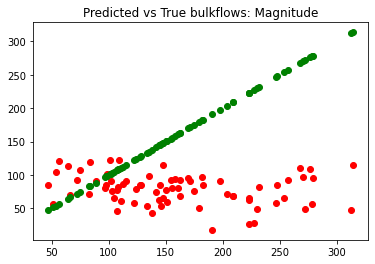

In [14]:
fig1 = plt.figure()
bx = fig1.add_subplot(1, 1, 1)
plt.scatter(bf, pred_bf, color='red')
plt.scatter(bf, bf, color='green')
plt.title('Predicted vs True bulkflows: Magnitude')

plt.show()


### save model

In [15]:
# model0.save('C:/Users/yaras/Documents/Research/Feldman/saved-models/trained-models/relu_model')

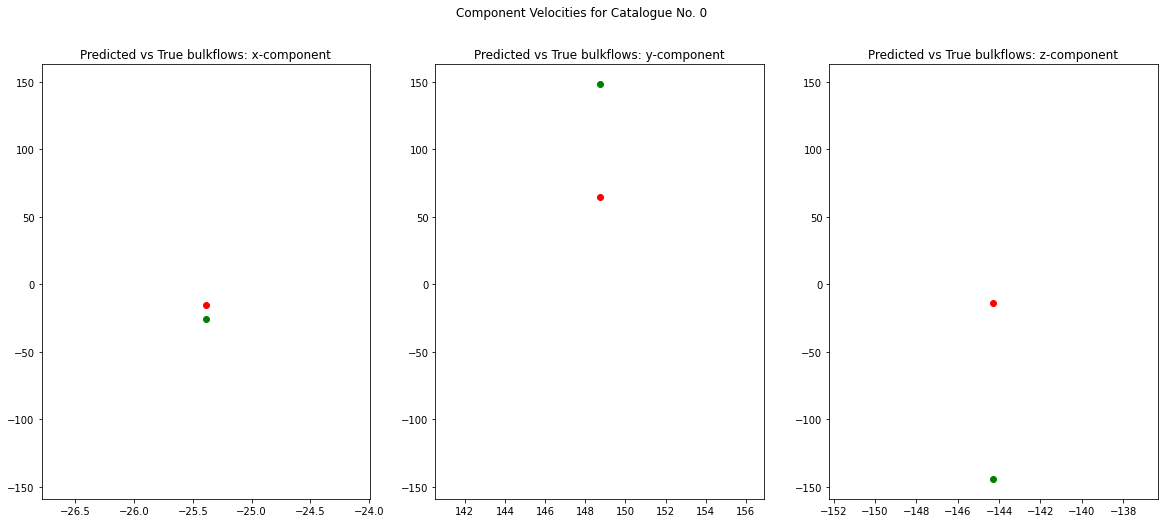

In [16]:
# to help with visualization
# Enter the number of the catalogue you want to view the component velocities for

# enter number of catalogue you want to view
# must be an integer, and must be 0 <= num < len(output_pred[:,1])
# if the number does not follow these rules, it will produce an error
num = 0  # change this as needed

fig = plt.figure()
fig.set_figheight(8) 
fig.set_figwidth(20)
fig.suptitle(f'Component Velocities for Catalogue No. {num}')

bx = fig.add_subplot(1, 3, 1)
plt.scatter(output_test[:, 0][num], output_pred[:, 0][num], color='red')
plt.scatter(output_test[:, 0][num], output_test[:, 0][num], color='green')
plt.title('Predicted vs True bulkflows: x-component')


by = fig.add_subplot(1, 3, 2, sharey=bx)
plt.scatter(output_test[:, 1][num], output_pred[:, 1][num], color='red')
plt.scatter(output_test[:, 1][num], output_test[:, 1][num], color='green')
plt.title('Predicted vs True bulkflows: y-component')

bz = fig.add_subplot(1, 3, 3, sharey=bx)
plt.scatter(output_test[:, 2][num], output_pred[:, 2][num], color='red')
plt.scatter(output_test[:, 2][num], output_test[:, 2][num], color='green')
plt.title('Predicted vs True bulkflows: z-component')

plt.show()

In [17]:
# import numpy as np
# lens = []
# for i in range(3000):
#     data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-{i}-error-40.npy.npz')
#     data = data['data']
#     lens.append(data.shape[0])
    
# print(min(lens))
# print(max(lens))